## Структура

0. Импорт библиотек
1. Импорт STL файлов
2. Импорт CSV с результатами отклонений
3. Анализ и обработка данных (пропуски, выбросы, нормализация и стандартизация данных)
4. Архитектура и обучение нейронной сети
5. Анализ результатов

### 0. Импорт библиотек

In [1]:
import numpy as np  # работа с массивами
import pandas as pd  # работа с данными (таблицами)
import matplotlib.pyplot as plt  # визуализация
import seaborn as sns  # визуализация в статистике
from stl import mesh  # работа с STL моделями
import vtkplotlib as vpl  # визуализация STL

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
import tensorflow as tf

%matplotlib inline

### 1. Импорт STL - моделей

In [2]:
mesh_initial = mesh.Mesh.from_file('model_stl\\VKR\\ini.stl')
mesh_deform = mesh.Mesh.from_file('model_stl\\VKR\\def.stl')
mesh_predef = mesh.Mesh.from_file('model_stl\\VKR\\ini.stl')
vpl.mesh_plot(mesh_initial)
vpl.mesh_plot(mesh_deform, color='red')
# vpl.show()

### 2. Импорт CSV-файлов с результатами отклонений

In [3]:
csv_data = pd.read_csv('model_stl\\VKR\\dev_full.asc',
                       sep=' ',
                       decimal=',',
                       names=['X','Y','Z','nx','ny','nz','dx','dy','dz','dev'])
csv_data.head()

X     Y         Z        nx   ny        nz  dx  dy  dz  dev
0  21.147761  14.7  31.15472 -0.372583  0.0 -0.927999 NaN NaN NaN  NaN
1  21.147761  15.1  31.15472 -0.372583  0.0 -0.927999 NaN NaN NaN  NaN
2  21.147761  15.5  31.15472 -0.372583  0.0 -0.927999 NaN NaN NaN  NaN
3  21.147761  15.9  31.15472 -0.372583  0.0 -0.927999 NaN NaN NaN  NaN
4  21.147761  16.3  31.15472 -0.372583  0.0 -0.927999 NaN NaN NaN  NaN

### 3. Анализ и обработка данных (пропуски, масштабирование, выбросы, нормализация данных)

In [4]:
# описательная статистика
round(csv_data.describe(), 3)

X           Y           Z          nx          ny          nz  \
count  449427.000  449427.000  449427.000  449427.000  449427.000  449427.000   
mean      -10.561      14.938      15.644       0.001      -0.020      -0.006   
std        28.195       5.622      15.706       0.460       0.718       0.521   
min       -58.000       5.500     -15.500      -1.000      -1.000      -1.000   
25%       -32.966      10.887       4.208      -0.000      -0.800      -0.031   
50%       -14.115      15.150      15.288       0.000       0.000       0.000   
75%        21.188      18.500      27.342       0.000       0.741       0.000   
max        35.000      25.500      48.000       1.000       1.000       1.000   

               dx          dy          dz         dev  
count  166009.000  166009.000  166009.000  166009.000  
mean       -0.006      -0.026       0.000      -0.103  
std         0.086       0.222       0.094       0.236  
min        -0.880      -0.572      -0.658      -1.106  
25%        -0.003      -0.184      -0.002      -0.262  
50%         0.000      -0.002       0.000      -0.123  
75%         0.008       0.019       0.002       0.063  
max         0.987       1.069       2.549       2.553

In [5]:
# определение количества пропусков
csv_data.isna().sum()

X           0
Y           0
Z           0
nx          0
ny          0
nz          0
dx     283418
dy     283418
dz     283418
dev    283418
dtype: int64

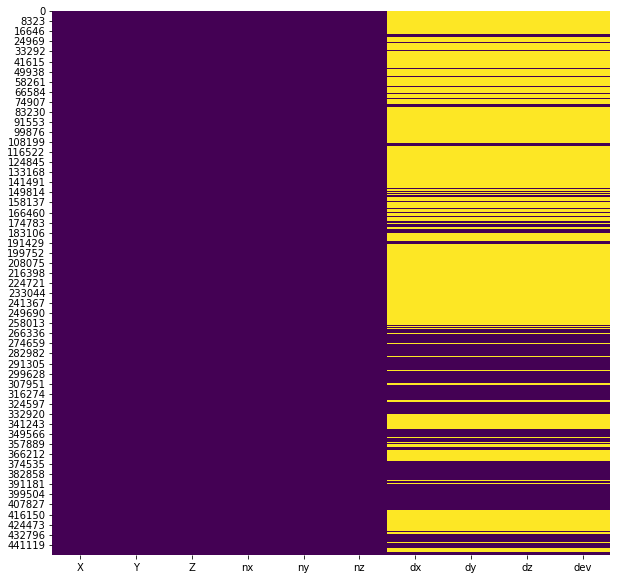

In [6]:
# визуализируем пропуски
plt.figure(figsize=(10,10))
sns.heatmap(csv_data.isna(), cmap='viridis', cbar=False)
plt.show()

In [7]:
# удаление строк с пропущенными значениями
csv_data = csv_data.dropna()
csv_data.isna().sum()

X      0
Y      0
Z      0
nx     0
ny     0
nz     0
dx     0
dy     0
dz     0
dev    0
dtype: int64

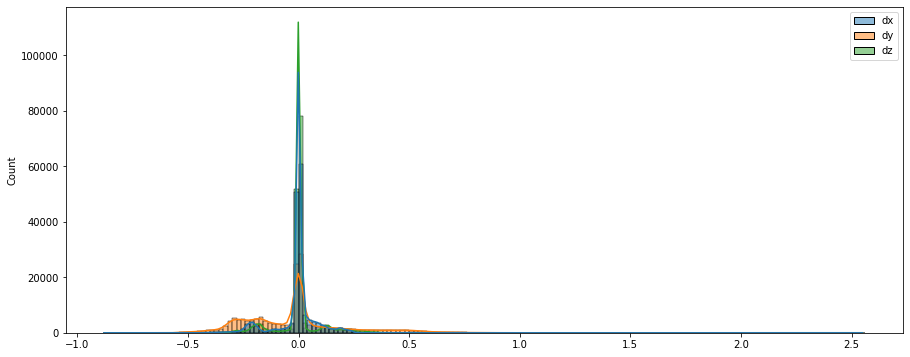

In [8]:
# количественный анализ до обработки
plt.figure(figsize=(15,6))
sns.histplot(data=csv_data[['dx', 'dy', 'dz']], kde=True, binwidth=0.02)
plt.show()

In [9]:
#масштабирование, приведение к нормальному закому распределения
from sklearn.preprocessing import QuantileTransformer
quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=42)
csv_data_quantile = csv_data.copy()
csv_data_quantile[['dx', 'dy', 'dz']] = quantile_transformer.fit_transform(csv_data[['dx', 'dy', 'dz']])
csv_data_quantile.describe()

X              Y              Z             nx  \
count  166009.000000  166009.000000  166009.000000  166009.000000   
mean      -20.298227      14.425870      16.023393       0.004362   
std        25.605953       7.002921      18.024059       0.436209   
min       -58.000000       5.500000     -15.500000      -1.000000   
25%       -39.347112       8.150000       1.000000       0.000000   
50%       -22.852083      12.514062      16.003516       0.000000   
75%        -5.000000      19.560000      29.960937       0.000000   
max        35.000000      25.500000      48.000000       1.000000   

                  ny             nz             dx             dy  \
count  166009.000000  166009.000000  166009.000000  166009.000000   
mean        0.001295       0.000150      -0.000050       0.004217   
std         0.799945       0.412062       0.997933       1.000017   
min        -1.000000      -1.000000      -5.199338      -5.199338   
25%        -1.000000       0.000000      -0.673677      -0.672821   
50%         0.000000       0.000000      -0.002803       0.007015   
75%         1.000000       0.000000       0.675301       0.679626   
max         1.000000       1.000000       5.199338       5.199338   

                  dz            dev  
count  166009.000000  166009.000000  
mean       -0.001601      -0.103476  
std         0.999072       0.236194  
min        -5.199338      -1.106201  
25%        -0.675453      -0.262255  
50%        -0.003764      -0.123407  
75%         0.669884       0.062655  
max         5.199338       2.553010

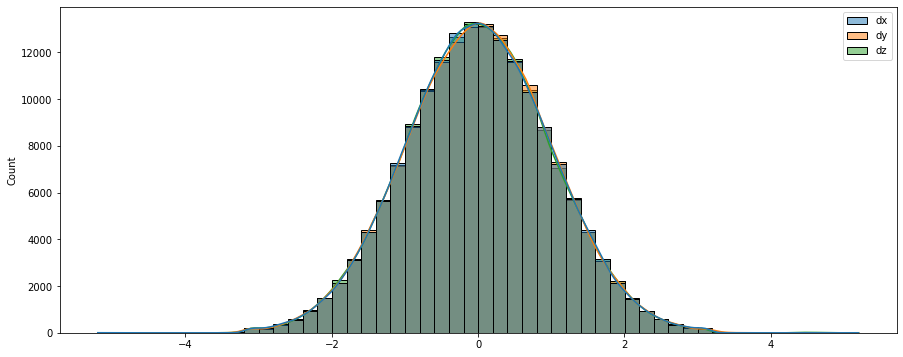

In [10]:
#количественный анализ после маштабирования
plt.figure(figsize=(15,6))
sns.histplot(data=csv_data_quantile[['dx', 'dy', 'dz']], kde=True, binwidth=0.2)
plt.show()

<AxesSubplot:>

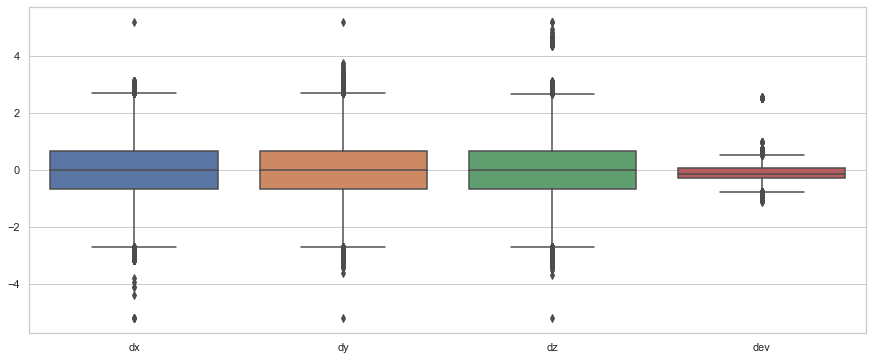

In [11]:
#ящики с усами до удаления выбросов
sns.set(style='whitegrid')
plt.figure(figsize=(15,6))
sns.boxplot(data=csv_data_quantile[['dx', 'dy', 'dz','dev']])

<Figure size 720x360 with 0 Axes>

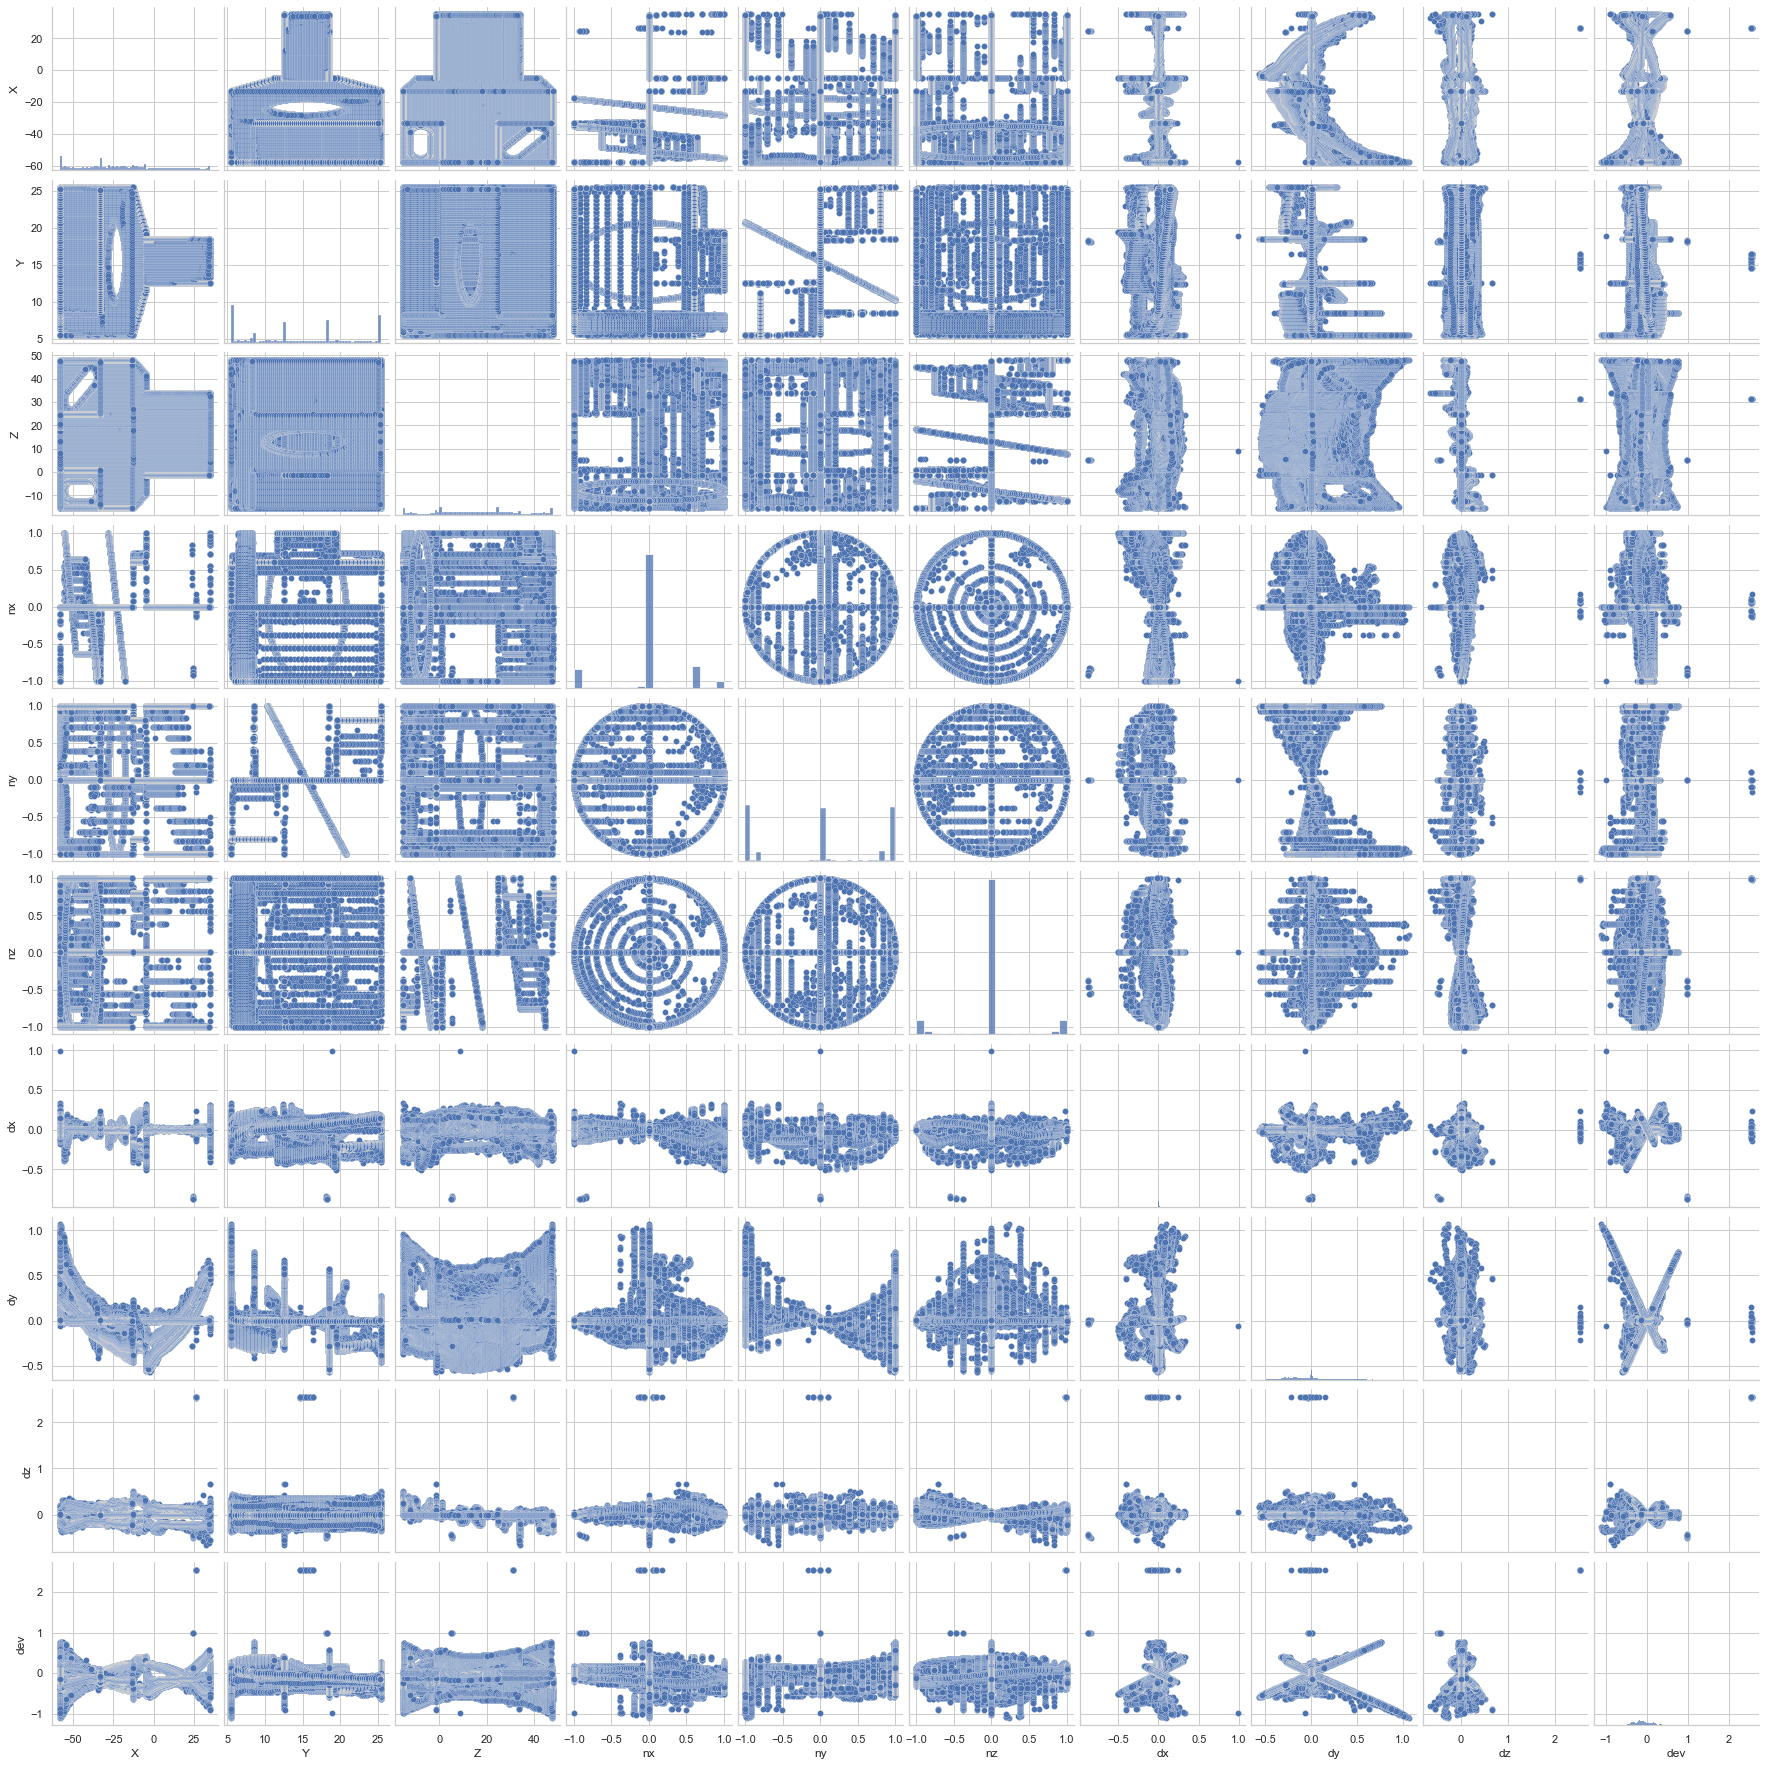

In [12]:
#график попарного распределения переменных до масштабирования
sns.set(style='whitegrid')
plt.figure(figsize=(10,5))
sns.pairplot(data=csv_data, plot_kws=dict(linewidth=0.2))
plt.show()

In [13]:
# удаление выбросов по методу 3-х сигм
low_dx = csv_data_quantile.dx.quantile(q=0.003)
upp_dx = csv_data_quantile.dx.quantile(q=0.997)
low_dy = csv_data_quantile.dy.quantile(q=0.003)
upp_dy = csv_data_quantile.dy.quantile(q=0.997)
low_dz = csv_data_quantile.dz.quantile(q=0.003)
upp_dz = csv_data_quantile.dz.quantile(q=0.997)

csv_data_quantile_n = csv_data_quantile.copy()
csv_data_quantile_n = csv_data_quantile[(csv_data_quantile.dx > low_dx) & (csv_data_quantile.dx < upp_dx) & (csv_data_quantile.dy > low_dy) & (csv_data_quantile.dy < upp_dy) & (csv_data_quantile.dz > low_dz) & (csv_data_quantile.dz < upp_dz)]

csv_data_quantile_n.describe()

X              Y              Z             nx  \
count  163079.000000  163079.000000  163079.000000  163079.000000   
mean      -20.430924      14.451614      16.006559      -0.003008   
std        25.626636       7.023481      17.922264       0.433400   
min       -58.000000       5.500000     -15.500000      -1.000000   
25%       -39.350000       8.121250       1.000000       0.000000   
50%       -23.246875      12.500000      16.003516       0.000000   
75%        -5.001342      19.593750      29.686719       0.000000   
max        35.000000      25.500000      48.000000       1.000000   

                  ny             nz             dx             dy  \
count  163079.000000  163079.000000  163079.000000  163079.000000   
mean        0.003203      -0.000217       0.005934       0.003777   
std         0.802167       0.410706       0.964162       0.976605   
min        -1.000000      -1.000000      -2.748757      -2.729161   
25%        -1.000000       0.000000      -0.659030      -0.668886   
50%         0.000000       0.000000      -0.001603       0.005260   
75%         1.000000       0.000000       0.665153       0.672910   
max         1.000000       1.000000       2.752637       2.760278   

                  dz            dev  
count  163079.000000  163079.000000  
mean       -0.001490      -0.099144  
std         0.972211       0.225741  
min        -2.754644      -0.800103  
25%        -0.664983      -0.252774  
50%        -0.002927      -0.120703  
75%         0.660611       0.063723  
max         2.747487       0.767073

In [14]:
# нормализация (-1, 1)
from sklearn.preprocessing import MinMaxScaler
minmax_scaler_X = MinMaxScaler(feature_range=(-1, 1))
minmax_scaler_y = MinMaxScaler(feature_range=(-1, 1))
csv_data_nrm = csv_data_quantile_n.copy()
csv_data_nrm[['X','Y','Z','nx','ny','nz','dev']] = minmax_scaler_X.fit_transform(csv_data_quantile_n[['X','Y','Z','nx','ny','nz','dev']])
csv_data_nrm[['dx','dy','dz']] = minmax_scaler_y.fit_transform(csv_data_quantile_n[['dx','dy','dz']])
csv_data_nrm.describe()

X              Y              Z             nx  \
count  163079.000000  163079.000000  163079.000000  163079.000000   
mean       -0.192063      -0.104839      -0.007667      -0.003008   
std         0.551110       0.702348       0.564481       0.433400   
min        -1.000000      -1.000000      -1.000000      -1.000000   
25%        -0.598925      -0.737875      -0.480315       0.000000   
50%        -0.252621      -0.300000      -0.007763       0.000000   
75%         0.139756       0.409375       0.423204       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

                  ny             nz             dx             dy  \
count  163079.000000  163079.000000  163079.000000  163079.000000   
mean        0.003203      -0.000217       0.001452      -0.004292   
std         0.802167       0.410706       0.350516       0.355812   
min        -1.000000      -1.000000      -1.000000      -1.000000   
25%        -1.000000       0.000000      -0.240292      -0.249368   
50%         0.000000       0.000000      -0.001288      -0.003752   
75%         1.000000       0.000000       0.241107       0.239497   
max         1.000000       1.000000       1.000000       1.000000   

                  dz            dev  
count  163079.000000  163079.000000  
mean        0.000759      -0.105449  
std         0.353394       0.288086  
min        -1.000000      -1.000000  
25%        -0.240417      -0.301509  
50%         0.000237      -0.132963  
75%         0.241430       0.102398  
max         1.000000       1.000000

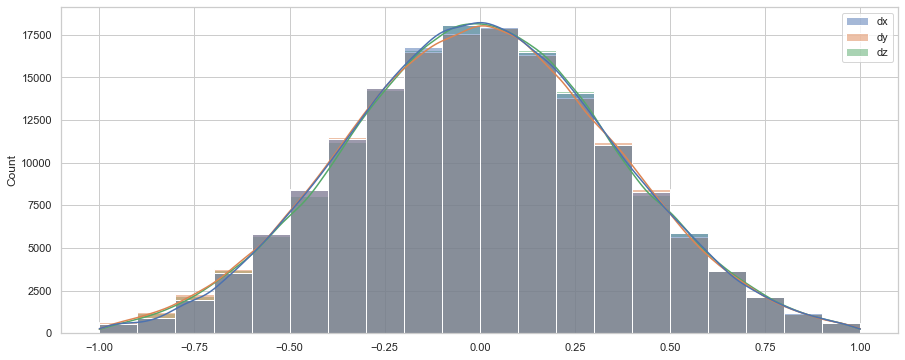

In [15]:
# количественный анализ после удаления выбросов и нормализации
plt.figure(figsize=(15,6))
sns.histplot(data=csv_data_nrm[['dx', 'dy', 'dz']], kde=True, binwidth=0.1)
plt.show()

<AxesSubplot:>

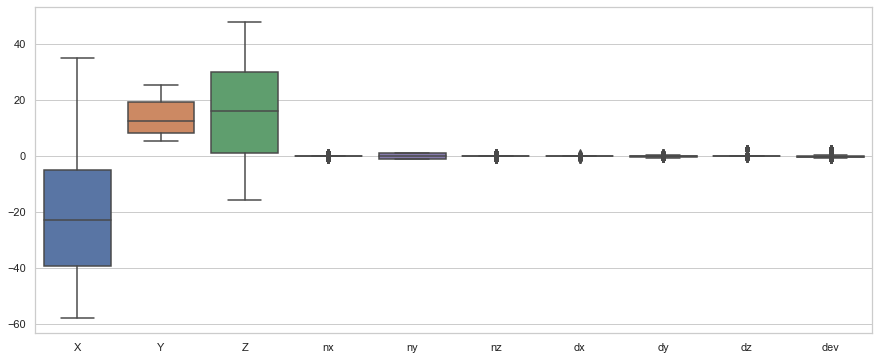

In [16]:
# ящики с усами исходных данных
sns.set(style='whitegrid')
plt.figure(figsize=(15,6))
sns.boxplot(data=csv_data)

<AxesSubplot:>

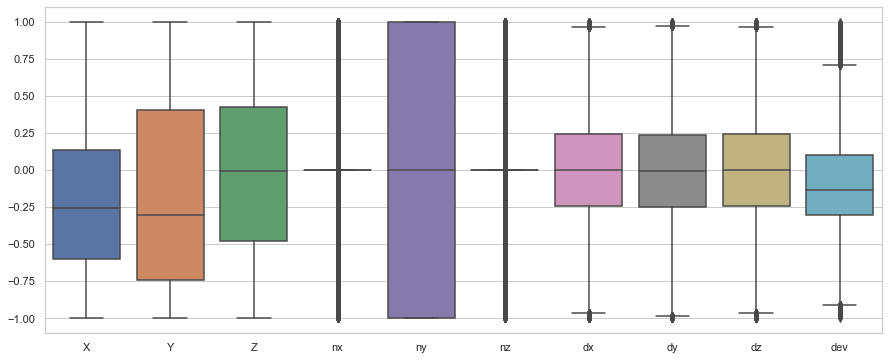

In [17]:
# ящики с усами после масштабирования, удаления выбросов и нормализации
sns.set(style='whitegrid')
plt.figure(figsize=(15,6))
sns.boxplot(data=csv_data_nrm)

<Figure size 720x360 with 0 Axes>

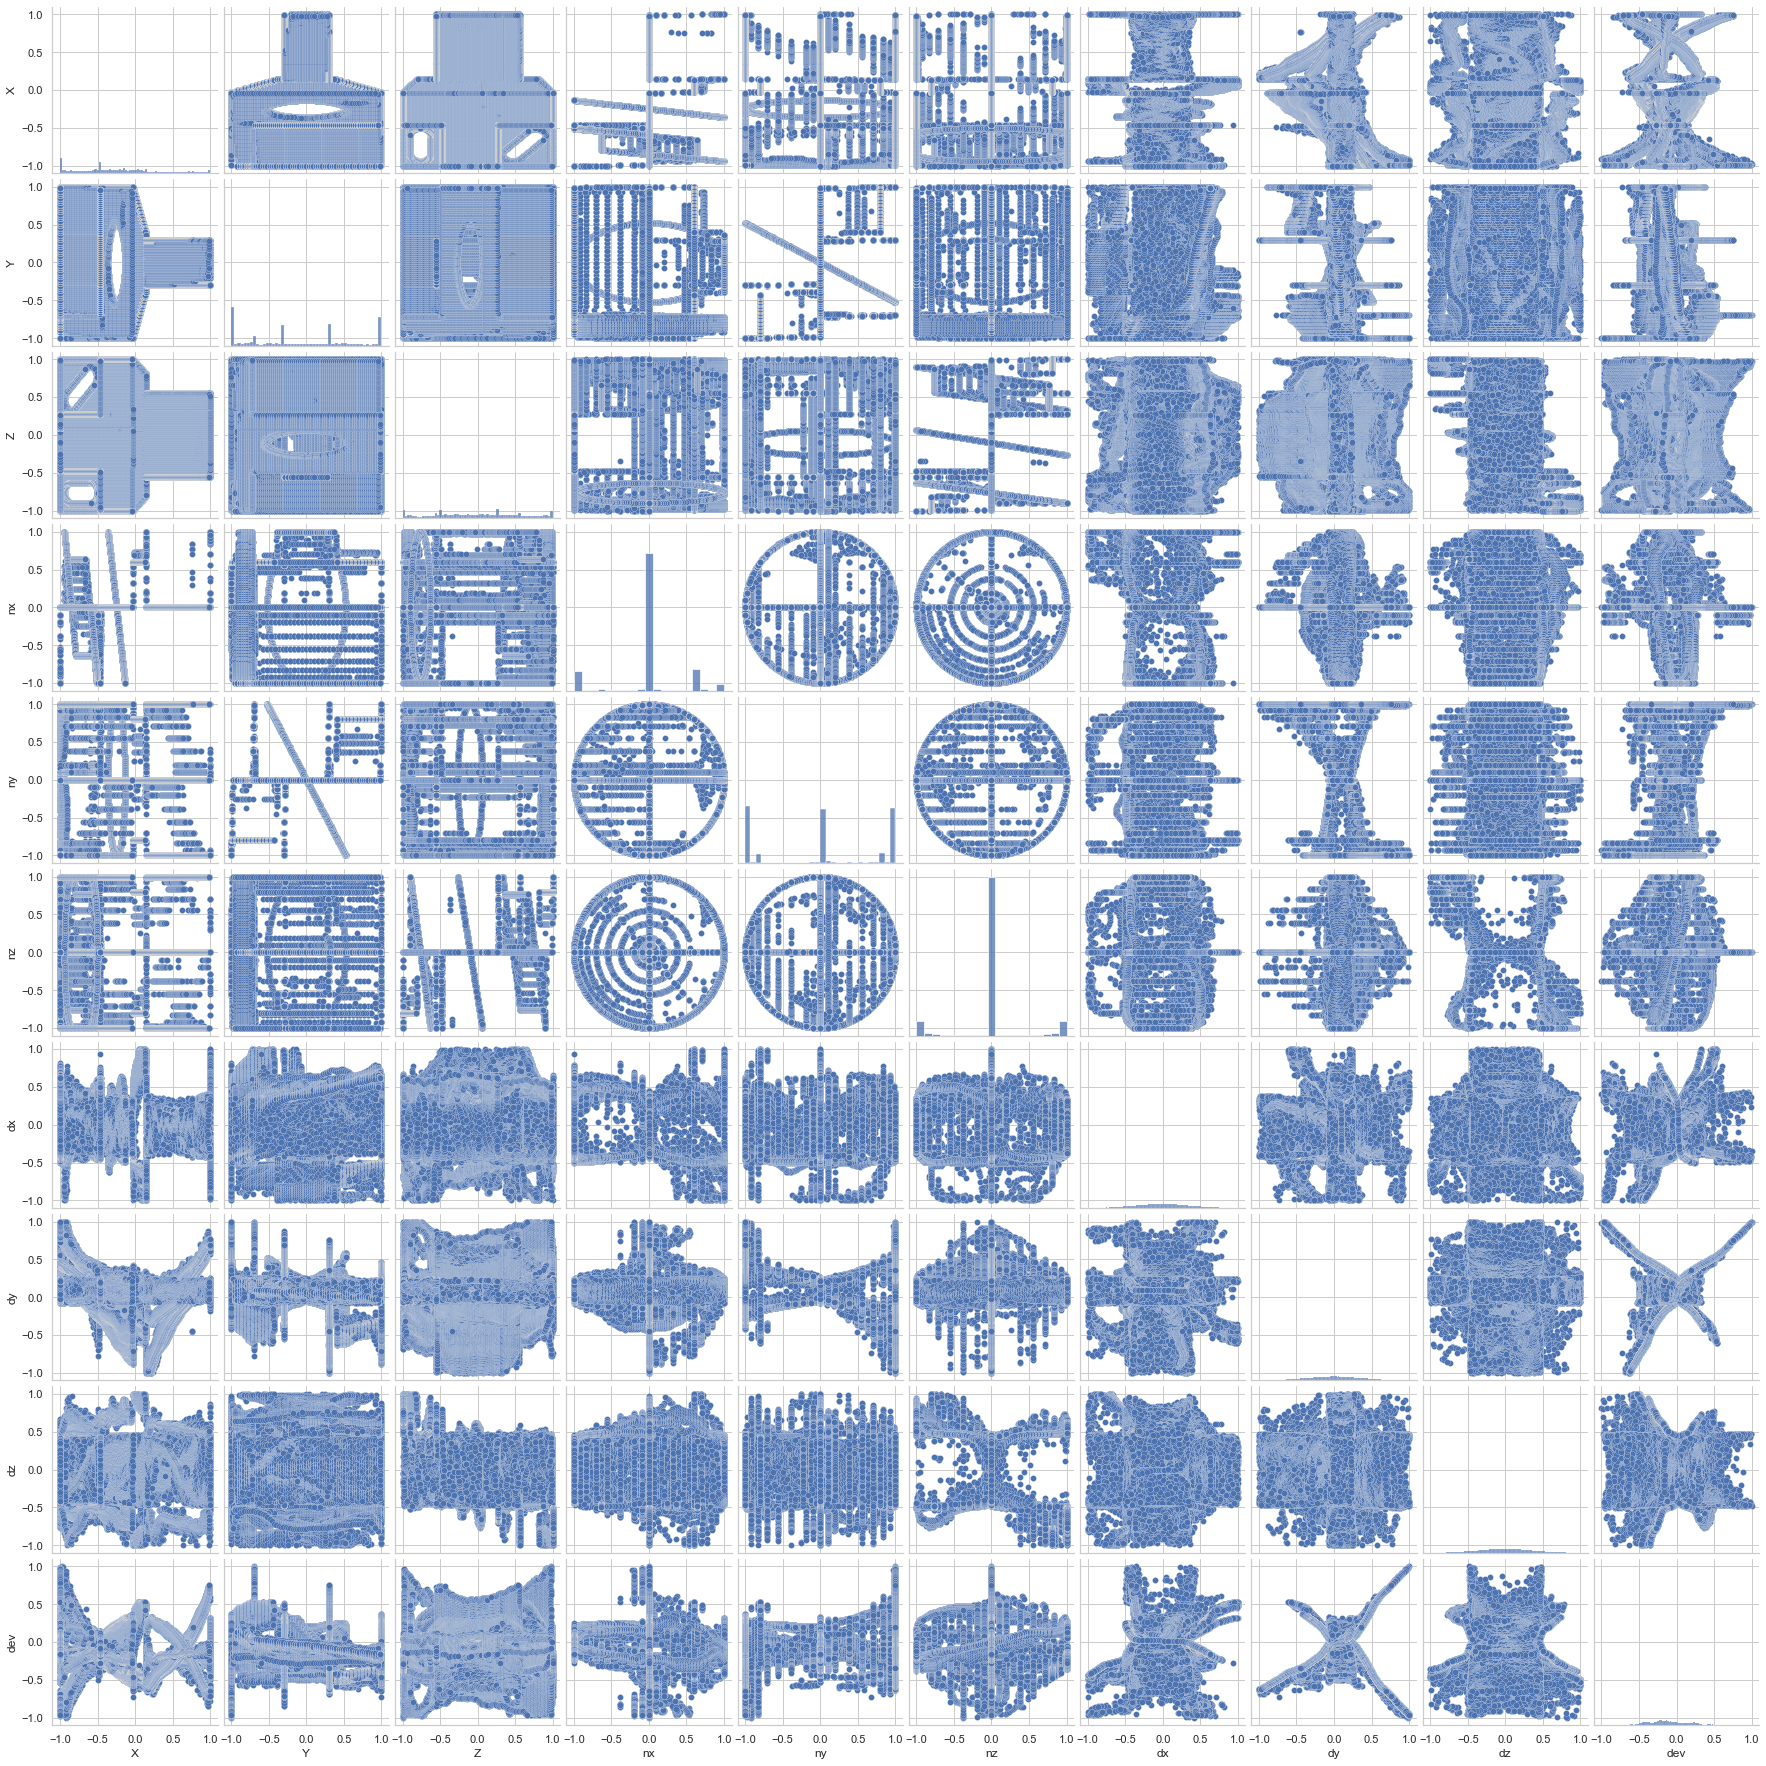

In [18]:
# график попарного распределения переменных после масштабирования, удаления выбросов и нормализации
sns.set(style='whitegrid')
plt.figure(figsize=(10,5))
sns.pairplot(data=csv_data_nrm, plot_kws=dict(linewidth=0.2))
plt.show()

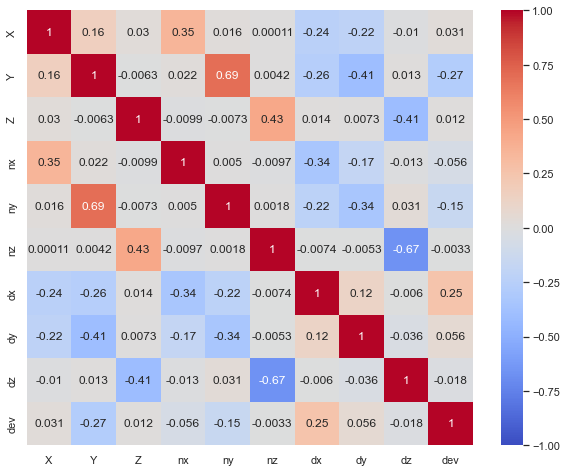

In [19]:
csv_data_nrm_corr = csv_data_nrm.corr()
plt.figure(figsize=(10,8))
sns.heatmap(data=csv_data_nrm_corr, vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.show()

### 4. Архитектура и обучение нейронной сети

In [20]:
X = np.array(csv_data_nrm[['X', 'Y', 'Z']]) # входные данные
y = np.array(csv_data_nrm[['dx', 'dy', 'dz']])  # выходные данные


# разделение данных на тренировочную и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, shuffle = True, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(138617, 3)
(138617, 3)
(24462, 3)
(24462, 3)


In [32]:
# архитектура нейронной сети
model = Sequential()
model.add(Dense(3, input_dim = X_train.shape[1], activation='linear')) # входной слой
# model.add(BatchNormalization())
model.add(Dense(64, activation= 'relu'))
# model.add(BatchNormalization())
model.add(Dense(64, activation= 'relu'))
# model.add(Dropout(0.2))
model.add(Dense(64, activation= 'relu'))
model.add(Dense(3, activation= 'linear'))

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError()]) # компиляция
model.summary() 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 3)                 12        
                                                                 
 dense_6 (Dense)             (None, 64)                256       
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dense_9 (Dense)             (None, 3)                 195       
                                                                 
Total params: 8,783
Trainable params: 8,783
Non-trainable params: 0
_________________________________________________________________


In [33]:
# Обучение нейронной сети
history = model.fit(X_train, y_train, epochs = 100, validation_data = (X_test, y_test), callbacks=[callback])
print(history.history.keys())

Epoch 1/100
4332/4332 [==============================] - 4s 775us/step - loss: 0.0489 - mean_absolute_error: 0.1641 - val_loss: 0.0374 - val_mean_absolute_error: 0.1379
Epoch 2/100
4332/4332 [==============================] - 3s 720us/step - loss: 0.0352 - mean_absolute_error: 0.1329 - val_loss: 0.0331 - val_mean_absolute_error: 0.1274te_error:
Epoch 3/100
4332/4332 [==============================] - 3s 718us/step - loss: 0.0310 - mean_absolute_error: 0.1226 - val_loss: 0.0280 - val_mean_absolute_error: 0.1151
Epoch 4/100
4332/4332 [==============================] - 3s 713us/step - loss: 0.0286 - mean_absolute_error: 0.1160 - val_loss: 0.0273 - val_mean_absolute_error: 0.1130
Epoch 5/100
4332/4332 [==============================] - 3s 692us/step - loss: 0.0270 - mean_absolute_error: 0.1116 - val_loss: 0.0250 - val_mean_absolute_error: 0.1058
Epoch 6/100
4332/4332 [==============================] - 3s 718us/step - loss: 0.0257 - mean_absolute_error: 0.1081 - val_loss: 0.0249 - val_mean_

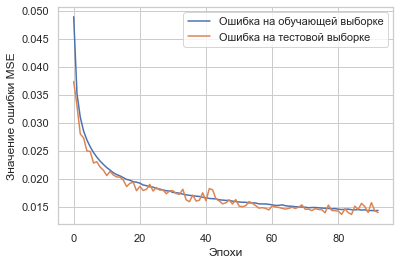

In [34]:
plt.plot(history.history['loss'], label = 'Ошибка на обучающей выборке')
plt.plot(history.history['val_loss'], label = 'Ошибка на тестовой выборке')
plt.xlabel('Эпохи')
plt.ylabel('Значение ошибки MSE')
plt.legend()
# plt.ylim(0,0.001)
plt.show()

### 5. Анализ результатов

In [24]:
# mesh_predef = mesh.Mesh.from_file('model_stl\\VKR\\ini.stl')

In [25]:
# нормализация данных для предсказания
mesh_predef_v0 = minmax_scaler_X.fit_transform(mesh_predef.v0)
mesh_predef_v1 = minmax_scaler_X.fit_transform(mesh_predef.v1)
mesh_predef_v2 = minmax_scaler_X.fit_transform(mesh_predef.v2)
mesh_predef_v0.min()

-1.0

In [26]:
# предсказание
resV0 = pd.DataFrame()
resV1 = pd.DataFrame()
resV2 = pd.DataFrame()
resV0[['Dx', 'Dy', 'Dz']] = model.predict(mesh_predef_v0)
resV1[['Dx', 'Dy', 'Dz']] = model.predict(mesh_predef_v1)
resV2[['Dx', 'Dy', 'Dz']] = model.predict(mesh_predef_v2)

print(resV0.max())


Dx    0.839242
Dy    0.838114
Dz    0.779140
dtype: float32


In [27]:
# обратная нормализация
resV0 = minmax_scaler_y.inverse_transform(resV0)
resV1 = minmax_scaler_y.inverse_transform(resV1)
resV2 = minmax_scaler_y.inverse_transform(resV2)
resV0.min()

-2.122218

In [28]:
# обратное масштабирование
resV0 = quantile_transformer.inverse_transform(resV0)
resV1 = quantile_transformer.inverse_transform(resV1)
resV2 = quantile_transformer.inverse_transform(resV2)
resV0.min()

c:\Python\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


-0.3733124

In [29]:
# предеформация 3d модели
mesh_predef.v0 = mesh_predef.v0 - resV0
mesh_predef.v1 = mesh_predef.v1 - resV1
mesh_predef.v2 = mesh_predef.v2 - resV2
mesh_predef.v0

array([[ 21.149166,  15.096372,  31.35509 ],
       [ 21.149166,  15.096372,  31.35509 ],
       [ 21.14912 ,  15.497128,  31.360243],
       ...,
       [-57.999252,   8.120417,  47.5059  ],
       [-57.99927 ,   8.119938,  47.754124],
       [-57.9993  ,   8.119419,  48.00238 ]], dtype=float32)

In [30]:
# визуализация 3d моделей
vpl.mesh_plot(mesh_initial)
vpl.mesh_plot(mesh_deform, color='red')
vpl.mesh_plot(mesh_predef, color='green')
# vpl.show()

In [31]:
# сохраниение предеформированной модели
# mesh_predef.save('model_stl\\VKR\\predef.stl')